**About** : This notebook is used to infer models.

In [ ]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [ ]:
cd ../src/

## Initialization

### Imports

In [3]:
import os
import torch

print(torch.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
torch.cuda.get_device_name(0)

1.14.0a0+410ce96


'Tesla V100-SXM2-32GB-LS'

In [4]:
import os
import re
import cv2
import sys
import glob
import json
import time
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import *

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [5]:
from utils.logger import Config, upload_to_kaggle

from params import *
from data.dataset import SignDataset
from data.preparation import *

from model_zoo.models import define_model
from utils.metrics import *
from utils.torch import load_model_weights
from utils.plots import plot_sample
# from utils.plots import plot_confusion_matrix

from inference.predict import predict, predict_tta
# from inference.main import *

In [6]:
df = prepare_data(DATA_PATH, "")

### Preprocessing

In [7]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    df = pd.read_parquet(pq_path)
    n_frames = int(len(df) / ROWS_PER_FRAME)
    data = df[['x', 'y', 'z']].values.reshape(n_frames, ROWS_PER_FRAME, 3)
    return df, data.astype(np.float32)

In [8]:
KEPT_LANDMARKS = [
    [10, 297, 284, 389, 454, 361, 397, 379, 400, 152, 176, 150, 172, 132, 234, 162, 54, 67],  # silhouette
    [61, 40, 37, 267, 270, 291, 91, 84, 314, 321, 191, 81, 13, 311, 415, 78, 88, 87, 317, 318, 308],  # lips
    [205, 425],  # cheeks
    [500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511], # arms
    [468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488],  # left hand
    [522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542],  # right hand
#     [374],  # left_eye
#     [296],  # left_eyebrow
#     [145],  # right_eye
#     [66],  # right_eyebrow
#     [1],  # nose
]
MAPPING = [11, 6, 2, 1, 5, 10] # + [3, 4, 8, 9, 7]

In [9]:
TO_AVG = [
    [466, 387, 385, 398, 263, 390, 374, 381, 362],  # left_eye
    [383, 293, 296, 285],  # left_eyebrow
    [246, 160, 158, 173, 33, 163, 145, 154, 133],  # right_eye
    [156, 63, 66, 55],  # right_eyebrow
    [1, 2, 98, 327, 168],  # nose
]

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Preprocessing(nn.Module):
    def __init__(self, type_embed, max_len=50):
        super(Preprocessing, self).__init__()

        self.type_embed = torch.from_numpy(type_embed[None, :].astype(np.float32))
        self.type_embed = self.type_embed.repeat(1000, 1)

        self.landmark_embed = torch.tensor(np.arange(120)).float().unsqueeze(0) + 1
        self.landmark_embed = self.landmark_embed.repeat(1000, 1)
        
#         self.ids = torch.from_numpy(np.sort(np.concatenate(KEPT_LANDMARKS)))
        self.ids = torch.tensor([
            10,  13,  37,  40,  54,  61,  67,  78,  81,  84,  87,  88,  91, 132,
            150, 152, 162, 172, 176, 191, 205, 234, 267, 270, 284, 291, 297, 308,
            311, 314, 317, 318, 321, 361, 379, 389, 397, 400, 415, 425, 454, 468,
            469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482,
            483, 484, 485, 486, 487, 488, 500, 501, 502, 503, 504, 505, 506, 507,
            508, 509, 510, 511, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531,
            532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542
        ])

        self.to_avg = [
            torch.tensor([466, 387, 385, 398, 263, 390, 374, 381, 362]),
            torch.tensor([383, 293, 296, 285]),
            torch.tensor([246, 160, 158, 173, 33, 163, 145, 154, 133]),
            torch.tensor([156, 63, 66, 55]),
            torch.tensor([1, 2, 98, 327, 168])
        ]

        self.hands = torch.tensor(
            [468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488] + 
            [522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542]
        )
        
        self.frames = torch.tensor(np.arange(1000) + 1)
        
        self.max_len = torch.tensor([max_len])
        self.min_1 = torch.tensor([1])

    def filter_sign(self, x):
        hands = x[:, self.hands, 0]
        nan_prop = torch.isnan(hands).float().mean(-1)            
        x = x[torch.where(nan_prop < 1)[0]]
        
        length = self.frames[:x.size(0)].max().unsqueeze(0)
        sz = torch.cat([length, self.max_len]).max()
        
        divisor = (((sz - self.max_len) > 0) * (sz / self.max_len) + 1).int()
#         if sz > 50:
#             print(sz, divisor)

        ids = (self.frames[:x.size(0)] % divisor) == 0
        
        return x[ids]
        
    def forward(self, x):
        x = self.filter_sign(x)
        n_frames = x.shape[0]     
        
        avg_ids = []
        for ids in self.to_avg:
            avg_id = x[:, ids].mean(1, keepdims=True)
            avg_ids.append(avg_id)

        x = torch.cat([x[:, self.ids]] + avg_ids, 1)

        type_embed = self.type_embed[:n_frames]
        landmark_embed = self.landmark_embed[:n_frames, :x.shape[1]]
        
        # Normalize & fill nans
        nonan = x[~torch.isnan(x)].view(-1, x.shape[-1])
        x = x - nonan.mean(0)[None, None, :]
        x = x / nonan.std(0, unbiased=False)[None, None, :]
        x[torch.isnan(x)] = 0

        # Concat
        x = torch.cat([
            type_embed.unsqueeze(-1), x # , landmark_embed.unsqueeze(-1)
        ], -1).transpose(1, 2)

# #         Resize
#         x = x.contiguous().view(x.size(0), -1).transpose(0, 1)
#         x = F.interpolate(x.unsqueeze(1), 50).squeeze(1)
#         x = x.transpose(0, 1).contiguous().view(50, 5, -1)
        
        # Crop
#         x = x[:self.max_len]
        
        return x

In [11]:
landmarks = np.sort(np.concatenate(KEPT_LANDMARKS))
type_embed = np.zeros(1000)

for subset, idx in zip(KEPT_LANDMARKS, MAPPING):
    type_embed[np.array(subset)] = idx
type_embed = type_embed[type_embed > 0]

type_embed = np.concatenate([type_embed, np.array([3, 4, 8, 9, 7])])

In [12]:
dataset = SignDataset(df, max_len=None, train=False)

In [13]:
prepro = Preprocessing(type_embed, max_len=40)

In [14]:
SAVE = False

SAVE_FOLDER = "../input/torch_3/"
os.makedirs(SAVE_FOLDER, exist_ok=True)

  0%|          | 0/94477 [00:00<?, ?it/s]

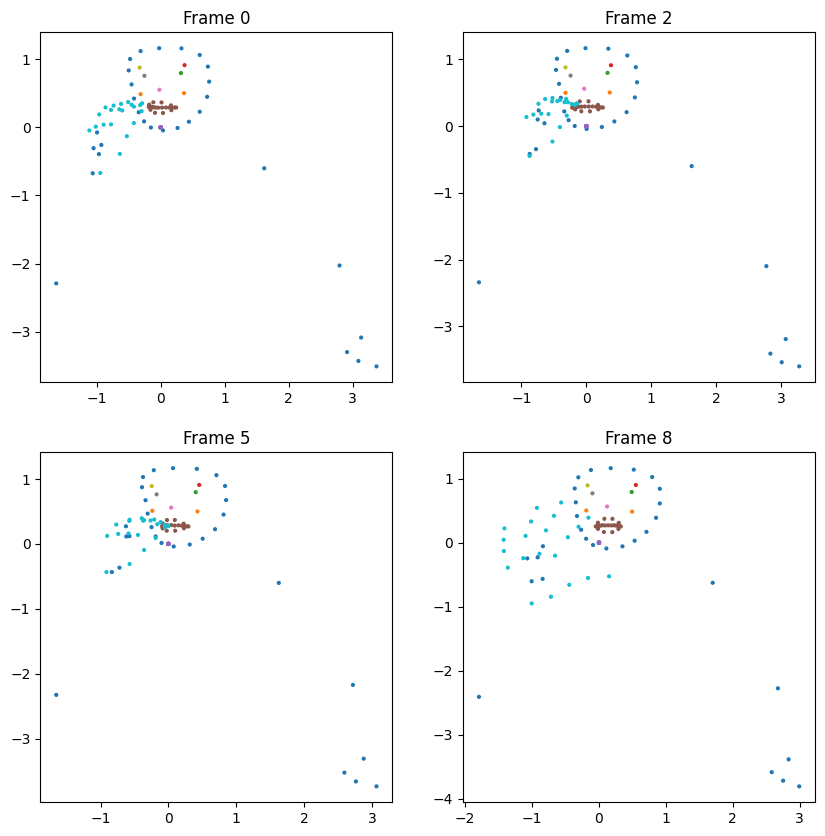

  0%|          | 0/94477 [00:00<?, ?it/s]

Prepro : 3.1ms


In [15]:
ts = []
lens = []

for i in tqdm(range(len(df['path']))):
    path = df['path'][i]
    name = f"{path.split('/')[-2]}_{path.split('/')[-1].split('.')[0]}.npy"
    
    if SAVE and os.path.exists(SAVE_FOLDER + name):
        continue

    pq, data = load_relevant_data_subset(path)
    data = torch.from_numpy(data)
    
    t0 = time.time()
    
    out_torch = prepro(data)
    
    lens.append(out_torch.size(0))

    assert len(out_torch)

    t1 = time.time()
    
    ts.append((t1 - t0) * 1000)

    if SAVE:
        np.save(SAVE_FOLDER + name, out_torch.numpy())

    if not (i % 10000):
        data = {
            "x": out_torch[:, 1],
            "y": out_torch[:, 2],
            "z": out_torch[:, 3],
            "type": out_torch[:, 0],
        }
        plot_sample(data, n_frames=4, figsize=(10, 10))
    
    break
    if not SAVE:
        if i > 1000:
            break

print(f'Prepro : {np.mean(ts) :.1f}ms')

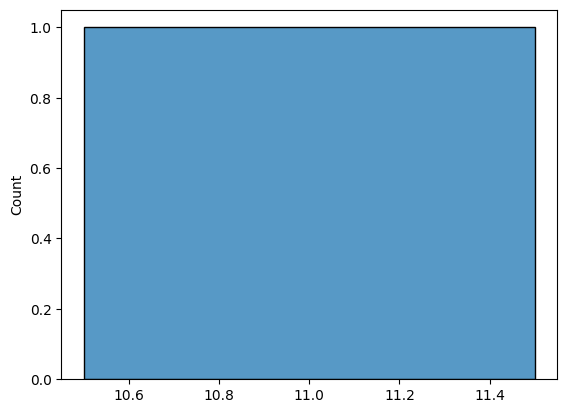

In [16]:
sns.histplot(lens)
plt.show()

Done ! 